# Interpolating between Images with a Wasserstein Autoencoder

This notebook provides you with a complete code example that trains a Wasserstein autoencoder on the Fashion-MNIST images and then uses the trained autoencoder to interpolate between Fashion-MNIST images moving in the latent space.

## Loading the Fashion-MNIST Dataset

The Fashion-MNIST dataset, created by Zalando, provides a new twist on the classic MNIST digit classification task. It consists of a training set with 60,000 images and a test set with 10,000 images. Each example is a 28 by 28 grayscale image, labeled across 10 different clothing and accessory categories.

Import the Fashion-MNIST dataset ...

In [1]:
import os
import deeptrack as dt

if not os.path.exists("FashionMNIST_dataset"):
    os.system("git clone https://github.com/DeepTrackAI/FashionMNIST_dataset")
    
data_dir = os.path.join("FashionMNIST_dataset")
train_files = dt.sources.ImageFolder(root=os.path.join(data_dir, "train"))
test_files = dt.sources.ImageFolder(root=os.path.join(data_dir, "test"))
files = dt.sources.Join(train_files, test_files)

print(len(train_files))
print(len(test_files))

60000
10000


... define the labels the classes of the Fashion-MNIST images ...

In [2]:
classes = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal",
           "Shirt", "Sneaker", "Bag", "Ankle boot"]

... create an image pipeline and a label pipeline ...

In [3]:
import torch

image_pipeline = (
    dt.LoadImage(files.path)
    >> dt.NormalizeMinMax()
    >> dt.MoveAxis(2, 0)
    >> dt.pytorch.ToTensor(dtype=torch.float)
)
label_pipeline = dt.Value(files.label_name[0]) >> int

2024-03-24 11:44:57.054395: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/giovannivolpe/miniconda3/envs/py310/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


... and some of the Fashio-MNIST images.

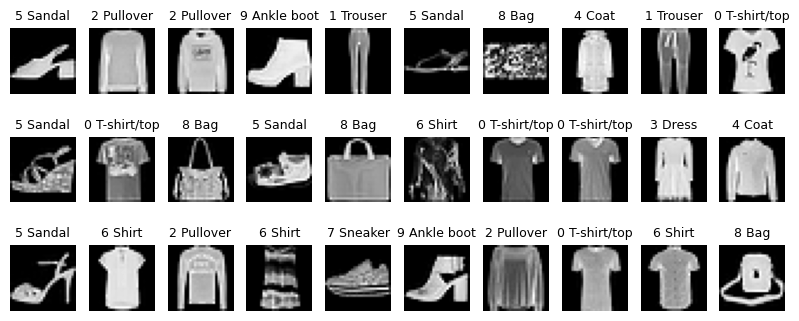

In [4]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(3, 10, figsize=((10, 4)))
for ax, train_file in zip(axs.ravel(), np.random.choice(train_files, axs.size)):
    image, label = (image_pipeline & label_pipeline)(train_file)
    ax.imshow(image.squeeze(), cmap="gray")
    ax.set_title(f"{int(label)} {classes[int(label)]}", fontsize=9)
    ax.set_axis_off()
plt.show()

## Training the Wasserstein Autoencoder

Define the Wasserstein autoencoder ...

In [5]:
import deeplay as dl

wae = dl.WassersteinAutoEncoder(
    channels=[32, 64, 128],
    latent_dim=20,
    reconstruction_loss=torch.nn.MSELoss(reduction="mean"),
).create()

print(wae)

WassersteinAutoEncoder(
  (encoder): ConvolutionalEncoder2d(
    (blocks): LayerList(
      (0): PoolLayerActivationNormalization(
        (pool): Identity()
        (layer): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
        (normalization): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): PoolLayerActivationNormalization(
        (pool): Identity()
        (layer): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (activation): ReLU()
        (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (2): PoolLayerActivationNormalization(
        (pool): Identity()
        (layer): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (activation): ReLU()
        (normalization): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (postprocess

... define the data loader ...

In [6]:
from torch.utils.data import DataLoader

train_dataset = dt.pytorch.Dataset(image_pipeline & image_pipeline,
                                   inputs=train_files)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

... train the Wasserstein autoencoder ...

In [7]:
wae_trainer = dl.Trainer(max_epochs=100)
wae_trainer.fit(wae, train_loader)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/Users/giovannivolpe/miniconda3/envs/py310/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: 
  | Name                | Type                   | Params
---------------------------------------------------------------
0 | encoder             | ConvolutionalEncoder2d | 93.1 K
1 | fc_enc              | Linear                 | 125 K 
2 | fc_dec              | Linear                 | 131 

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


... and it in evaluation mode.

In [8]:
wae.eval()

WassersteinAutoEncoder(
  (encoder): ConvolutionalEncoder2d(
    (blocks): LayerList(
      (0): PoolLayerActivationNormalization(
        (pool): Identity()
        (layer): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
        (normalization): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): PoolLayerActivationNormalization(
        (pool): Identity()
        (layer): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (activation): ReLU()
        (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (2): PoolLayerActivationNormalization(
        (pool): Identity()
        (layer): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (activation): ReLU()
        (normalization): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (postprocess

## Reconstructing the Fashion-MNIST Images

[]

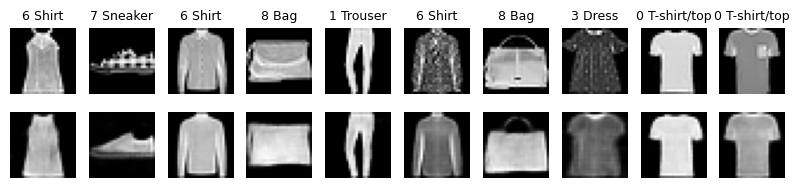

In [9]:
fig, axs = plt.subplots(2, 10, figsize=((10, 2)))
for i, test_file in enumerate(np.random.choice(test_files, 10)):
    image, label = (image_pipeline & label_pipeline)(test_file)
    axs[0, i].imshow(image.squeeze(), cmap="gray")
    axs[0, i].set_title(f"{int(label)} {classes[int(label)]}", fontsize=9)
    axs[0, i].set_axis_off()

    reconstructed_image, _ = wae(image.unsqueeze(0))
    axs[1, i].imshow(reconstructed_image.detach().squeeze(), cmap="gray")
    axs[1, i].set_axis_off()
plt.plot()

## Generating Images with the Decoder

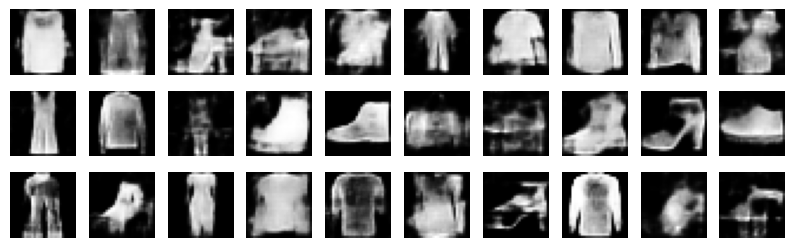

In [11]:
images = wae.decode(torch.randn(30, wae.latent_dim)).detach().squeeze()

fig, axs = plt.subplots(3, 10, figsize=((10, 3)))
for ax, image in zip(axs.ravel(), images):
    ax.imshow(image, cmap="gray")
    ax.set_axis_off()
plt.show()

## Morphing Images by Moving in the Latent Space

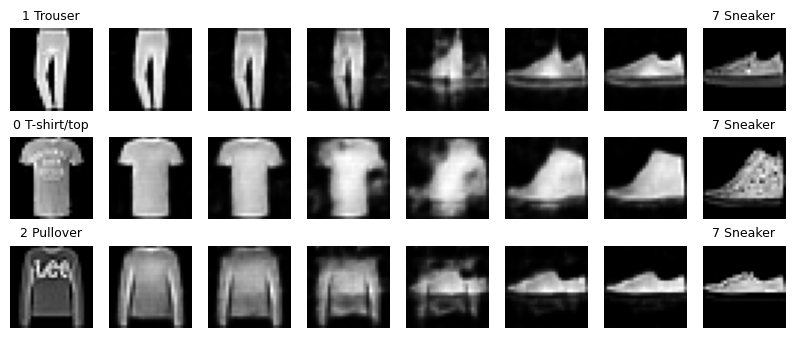

In [12]:
steps = 6

fig, axs = plt.subplots(3, steps + 2, figsize=((10, 4)))
for i, _ in enumerate(axs):
    test_file_0, test_file_1 = np.random.choice(test_files, 2)

    image_0, label_0 = (image_pipeline & label_pipeline)(test_file_0)
    z_0 = wae.encode(image_0.unsqueeze(0))

    image_1, label_1 = (image_pipeline & label_pipeline)(test_file_1)
    z_1 = wae.encode(image_1.unsqueeze(0))

    axs[i, 0].imshow(image_0.squeeze(), cmap="gray")
    axs[i, 0].set_title(f"{int(label_0)} {classes[int(label_0)]}", fontsize=9)
    axs[i, 0].set_axis_off()

    for step in range(steps):
        z_step = z_0 + (z_1 - z_0) * step / (steps - 1)
        image_step = wae.decode(z_step).detach()
        axs[i, step + 1].imshow(image_step.squeeze(), cmap="gray")
        axs[i, step + 1].set_axis_off()

    axs[i, -1].imshow(image_1.squeeze(), cmap="gray")
    axs[i, -1].set_title(f"{int(label_1)} {classes[int(label_1)]}", fontsize=9)
    axs[i, -1].set_axis_off()

plt.show()